# Install Dependecies

In [1]:
import os

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    exp_repo='https://github.com/MArpogaus/Bernstein-Experiments.git'
    %cd "/content/drive/MyDrive/probabilistic_power_forecast"
    if os.path.exists('./exp'):
      %cd exp
      !git fetch -p --force
      !git checkout FETCH_HEAD
    else:
      !git clone $exp_repo exp
      !git checkout dev
      %cd ./exp 
    !ls -la

    !pip install -Ue .

    !pip install -U git+https://github.com/MArpogaus/tensorflow-experiments@dev
    !pip install -U git+https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector.git@dev
except:
    %cd ..
    print('Not running in Colab')

/media/data/marcel/Dokumente/Studium/m.sc.informatik/Masterarbeit/paper_exp
Not running in Colab


# Import libraries

In [3]:
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='paper')

In [5]:
from matplotlib.patches import ConnectionPatch

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

In [7]:
tf.__version__

'2.3.0'

In [8]:
tfp.__version__

'0.11.1'

In [9]:
from pprint import pprint
from functools import partial

In [10]:
import tfexp

In [11]:
#from bernstein_flow.distributions.bernstein_flow_old import BernsteinFlow as BernsteinFlowOld 
from bernstein_flow.distributions import BernsteinFlow

In [12]:
from bernstein_flow.util.visualization import plot_flow
from bernstein_flow.util.visualization import plot_chained_bijectors

In [13]:
from bernstein_paper.distributions import MixedNormal
from bernstein_paper.distributions import NormalDistribution
from bernstein_paper.distributions import QuantileRegressionDistributionWrapper
from bernstein_paper.losses import PinballLoss
from bernstein_paper.losses import NegativeLogarithmicLikelihood
from bernstein_paper.metrics import MeanAbsoluteError, MeanSquaredError, ContinuousRankedProbabilityScore

# Define Paths

In [14]:
cfg_path='./configs_thesis'

# Function Definitions

In [15]:
def file_list(path, ending=''):
    if os.path.exists(path):
        return [
            os.path.join(path, file)
            for file in os.listdir(path)
            if file.endswith(ending)
            and os.path.getsize(os.path.join(path, file)) > 0]
    else:
        return []

In [16]:
def probabilistic_model_stats(probabilistic_model, pvector):
    if len(pvector) != 1:
        dfs=[]
        for i in range(len(pvector)):
            dfs.append(probabilistic_model_stats(probabilistic_model, pvector[i][None,...]))
        return pd.concat(dfs,ignore_index=True)
    else:
        dist = probabilistic_model(pvector)

        mu = np.squeeze(dist.mean())

        try:
            q05 = np.squeeze(dist.quantile(.05))
            q1 = np.squeeze(dist.quantile(.1))
            q2 = np.squeeze(dist.quantile(.2))
            q8 = np.squeeze(dist.quantile(.8))
            q9 = np.squeeze(dist.quantile(.9))
            q95 = np.squeeze(dist.quantile(.95))
        except Exception as ex:
            print(ex)
            q05 = None
            q1 = None
            q2 = None
            q8 = None
            q9 = None
            q95 = None

        df = pd.DataFrame(dict(
            mu=mu,
            q05=q05,
            q1=q1,
            q2=q2,
            q8=q8,
            q9=q9,
            q95=q95
        ))

        return df

In [17]:
def plot_probabilistic_forecast(
    parameter_model,
    probabilistic_model,
    x,
    ax=plt):

    pvector = parameter_model(x)
    dist = probabilistic_model(pvector)
    df = probabilistic_model_stats(probabilistic_model, pvector)

    t=np.arange(len(df.mu))
        
    ax.plot(
        t,
        df.mu,
        label='$\mu$',
        c="black"
    )

    
    if probabilistic_model != MixedNormal:
        ax.plot(t, df.q95,
                   label='$q(95%)$',
                   c="skyblue")
        ax.plot(t, df.q8,
                   label='$q(80%)$',
                   c="skyblue")
        ax.plot(t, df.q2,
                   label='$q(20%)$',
                   c="skyblue")
        ax.plot(t, df.q05,
                   label='$q(5%)$',
                   c="skyblue")

        ax.fill_between(
            t,
            df.q95,
            df.q05,
            alpha=0.2,
            label='$Q(90%)$',
            fc='skyblue'
        )

        ax.fill_between(
            t,
            df.q8,
            df.q2,
            alpha=0.5,
            label='$Q(60%)$',
            fc='skyblue'
        )

    ax.legend(loc='upper left')
    
    return df

In [18]:
def plot_dist(dist, y, ax=plt, color='skyblue'):

    dense_y = dist.prob(y).numpy()

    ax.fill_between(
        np.squeeze(y),
        np.squeeze(dense_y),
        np.min(dense_y),
        fc=color,
        alpha=0.8
    )

    ax.plot(
        y,
        dense_y,
        '-',
        color='white',
        linewidth=2
    )

In [19]:
def stacked_dist_plot(
        parameter_model,
        probabilistic_model,
        x,
        y,
        hspace=-.5,
        title=None
    ):
    yy = np.linspace(0-.5*np.abs(y.min()), y.max(), 200).astype(np.float32)
    yy = yy[...,tf.newaxis]
    horizon_size = y.shape[1]
    y=y.flatten()

    pv = parameter_model(x)
    dists = [
        probabilistic_model(pv[:,d]) for d in range(horizon_size)
    ]

    pal1 = sns.cubehelix_palette(horizon_size/2, rot=.55, light=.8, reverse=True).as_hex()
    pal2 = sns.cubehelix_palette(horizon_size/2, rot=.55, light=.8).as_hex()
    pal = pal1 + pal2

    fig , ax = plt.subplots(horizon_size,figsize=(16,horizon_size*0.4), sharex=True, sharey=True)

    if title is not None:
        fig.suptitle(title, fontsize=24)

    yaxis = ConnectionPatch(
        xyA=(0,0),
        xyB=(0,10),
        coordsA='data',
        coordsB='data',
        axesA=ax[-1],
        axesB=ax[0],
        color='black',
        lw=1.5,
        arrowstyle='->'
        #arrowstyle='Fancy, head_length=0.4, head_width=0.1, tail_width=0.3'
    )
    ax[0].add_artist(yaxis)
        
    for i in range(horizon_size):
        if i >= 1:
            con = ConnectionPatch(
                xyA=(y[i-1],0),
                xyB=(y[i],0),
                coordsA='data',
                coordsB='data',
                axesA=ax[i-1],
                axesB=ax[i],
                color=pal[i],
                lw=2+1*i/horizon_size,
                alpha=0.8
            )
            ax[i].add_artist(con)
        plot_dist(dists[i],yy,ax=ax[i],color=pal[i])
        ax[i].plot(
            y[i],
            0,
            '.',
            color=pal[i],
            markersize=8+8*i/horizon_size)

        ax[i].set_facecolor((0,0,0,0))
        ax[i].set_frame_on(False)
        ax[i].set_title('')
        ax[i].axis('off')

        ax[i].text(0, 0.1, i, fontweight="bold", fontsize='xx-large', color=pal[i],
                   ha="left", va="center", transform=ax[i].transAxes)

    fig.subplots_adjust(hspace=hspace)

    return fig, ax

In [20]:
def plot_chained_bijectors(flow):
    chained_bijectors = flow.bijector.bijector.bijectors
    base_dist = flow.distribution
    cols = len(chained_bijectors) +1
    fig, ax = plt.subplots(1,cols,figsize=(4*cols,4))
    
    n=200

    z_samples = np.linspace(-3,3,n).astype(np.float32)
    log_probs = base_dist.log_prob(z_samples)

    ax[0].plot(z_samples, np.exp(log_probs))

    zz = z_samples[...,None]
    ildj = 0.
    for i,(a,b) in enumerate(zip(ax[1:],chained_bijectors)):
        z = b.inverse(zz) # we need to use the inverse here since we are going from z->y!
        ildj += b.forward_log_det_jacobian(z,1)
        #print(z.shape, zz.shape, ildj.shape)
        a.plot(z, np.exp(log_probs + ildj))
        a.set_title(b.name.replace('_', ' '))
        a.set_xlabel(f'$z_{i}$')
        a.set_ylabel(f'$p(z_{i+1})$')
        zz = z
    fig.tight_layout()

In [21]:
def plot_save_plf(model_names,x,y,figsize=(16,8),postfix=None,concat_df=None):
    for a,m in zip(ax,model_names):
        fig = plt.figure(figsize=figsize)
        df=plot_probabilistic_forecast(
            models[m],
            prob_models[m],
            x=x)
        plt.plot(y.flatten(),color='orange',label='load')
        fig.suptitle(m.replace('_',' ').title())

        if postfix is not None:
            file_name=m + postfix + '.csv'
            file_path=os.path.join(csv_path,file_name)
            df['y']=y.flatten()
            if concat_df is not None:
                df = pd.concat([df,concat_df],axis='columns')
            df.index.name = 't'
            df.to_csv(file_path)

In [22]:
def flot_save_ridge_plots(model_names,x,y,postfix=None):
    for m in model_names:
        fig = stacked_dist_plot(models[m], prob_models[m], x, y)
        if postfix is not None:
            file_name=m + postfix + '.pgf'
            file_path=os.path.join(tikz_path,file_name)
            fig.savefig(file_path, bbox_inches='tight', transparent=True)

In [23]:
def score_observation(dist,y,ci=.90,tol=4):
    yl=(1-ci)/2
    yh=1-yl
    pv = param_model(x)
    dist = prob_model(pv)
    ql = np.reshape([
        m.bijector.forward(
            m.distribution.quantile(yl)
        ) for m in dist.distributions.model
    ],(1,48))
    qh = np.reshape([
        m.bijector.forward(
            m.distribution.quantile(yh)
        ) for m in dist.distributions.model
    ],(1,48))
    score = ((y<ql) | (y>qh)).sum(axis=1)
    return score <= tol

In [24]:
def anomalie_plot(prob_model, param_model,x,y,ci=.90,tol=4):
    pv = param_model(x)
    dist = prob_model(pv)
    score = score_observation(dist, y, ci=ci, tol=tol)

    c=['green' if ok else 'red' for ok in score]
    a=[.5 if ok else .05 for ok in score]


    fig = plt.figure(figsize=(16,8))
    for i in range(y.shape[0]):
        plt.plot(
            y[i],
            c=c[i],
            alpha=a[i]
        )
    plot_probabilistic_forecast(param_model, prob_model,x=x)

In [25]:
def patch_to_csv(x,y,file_name):
    df=pd.DataFrame(x.reshape(-1,3).copy(),columns=columns)
    df['y']=[np.nan]*(len(x)-48) + np.squeeze(y).tolist()
    df['load'][-48:] = np.nan
    df.plot(figsize=(16,8))
    df.index.name='t'
    df.to_csv(os.path.join(csv_path, file_name))

# Files

In [26]:
cfg_files=file_list(cfg_path,'yaml')
cfg_files

['./configs_thesis/wavenet_bernstein_flow.yaml',
 './configs_thesis/wavenet_gmm.yaml',
 './configs_thesis/feed_forward_gmm.yaml',
 './configs_thesis/feed_forward_bernstein_flow.yaml',
 './configs_thesis/wavenet.yaml',
 './configs_thesis/feed_forward.yaml']

In [27]:
cfgs = {c.name: c for c in list(map(tfexp.configuration.Configuration.from_yaml, cfg_files))}
cfgs

{'wavenet_bernstein_flow': Configuration(
   compile_kwds={   'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7f1b71c614f0>,
     'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1b70669550>},
   data_loader_kwds={   'batch_size': 32,
     'cycle_length': 10,
     'data_path': '../data/CER Electricity Revised March 2012/preprocessed/mini',
     'historic_columns': ['load', 'is_holiday', 'tempC'],
     'history_size': 336,
     'horizon_columns': ['is_holiday', 'tempC'],
     'horizon_size': 48,
     'prediction_columns': ['load'],
     'seed': 42,
     'shift': 48,
     'shuffle_buffer_size': 100,
     'validation_split': 0.1},
   data_preprocessor=None,
   evaluate_kwds={},
   fit_kwds={   'callbacks': [   <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f1b70608b80>,
     'epochs': 150,
     'shuffle': True,
     'validation_freq': 1},
   model_checkpoints='./logs_thesis/wavenet_bernste

In [28]:
for k in cfgs.keys():
    cfgs[k].model_checkpoints=cfgs[k].model_checkpoints.replace('logs/','logs_thesis/')

# Load Models (Checkpoint)

In [29]:
models = {cfg.name: tfexp.build_model(cfg) for cfg in cfgs.values()}

restoring model from checkpoint ./logs_thesis/wavenet_bernstein_flow/mcp/20200627-005522
restoring model from checkpoint ./logs_thesis/wavenet_gmm/mcp/20210109-220742
restoring model from checkpoint ./logs_thesis/feed_forward_gmm/mcp/20210110-115106
restoring model from checkpoint ./logs_thesis/feed_forward_bernstein_flow/mcp/20200615-162635
restoring model from checkpoint ./logs_thesis/wavenet/mcp/20210110-134543
restoring model from checkpoint ./logs_thesis/feed_forward/mcp/20210111-014443


In [30]:
for m in models.values():
    m.summary()

Model: "wavenet_bernstein_flow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 384, 20)           140       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 384, 20)           820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 384, 20)           820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 384, 20)           820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 384, 20)           820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 384, 20)           820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 384, 20)

# Plot History

In [31]:
read_csv = partial(pd.read_csv,index_col='epoch')

In [32]:
base_paths = {cfg.name: os.path.split(cfg.model_checkpoints)[0] for cfg in cfgs.values()}
base_paths

{'wavenet_bernstein_flow': './logs_thesis/wavenet_bernstein_flow',
 'wavenet_gmm': './logs_thesis/wavenet_gmm',
 'feed_forward_gmm': './logs_thesis/feed_forward_gmm',
 'feed_forward_bernstein_flow': './logs_thesis/feed_forward_bernstein_flow',
 'wavenet': './logs_thesis/wavenet',
 'feed_forward': './logs_thesis/feed_forward'}

In [33]:
hist_dfs = {
    k: pd.concat(
        (
            pd.read_csv(f)
            for f in sorted(file_list(v,'csv'))
        ),
        ignore_index=True
    )
    for k,v in base_paths.items() if len(file_list(v,'csv'))}

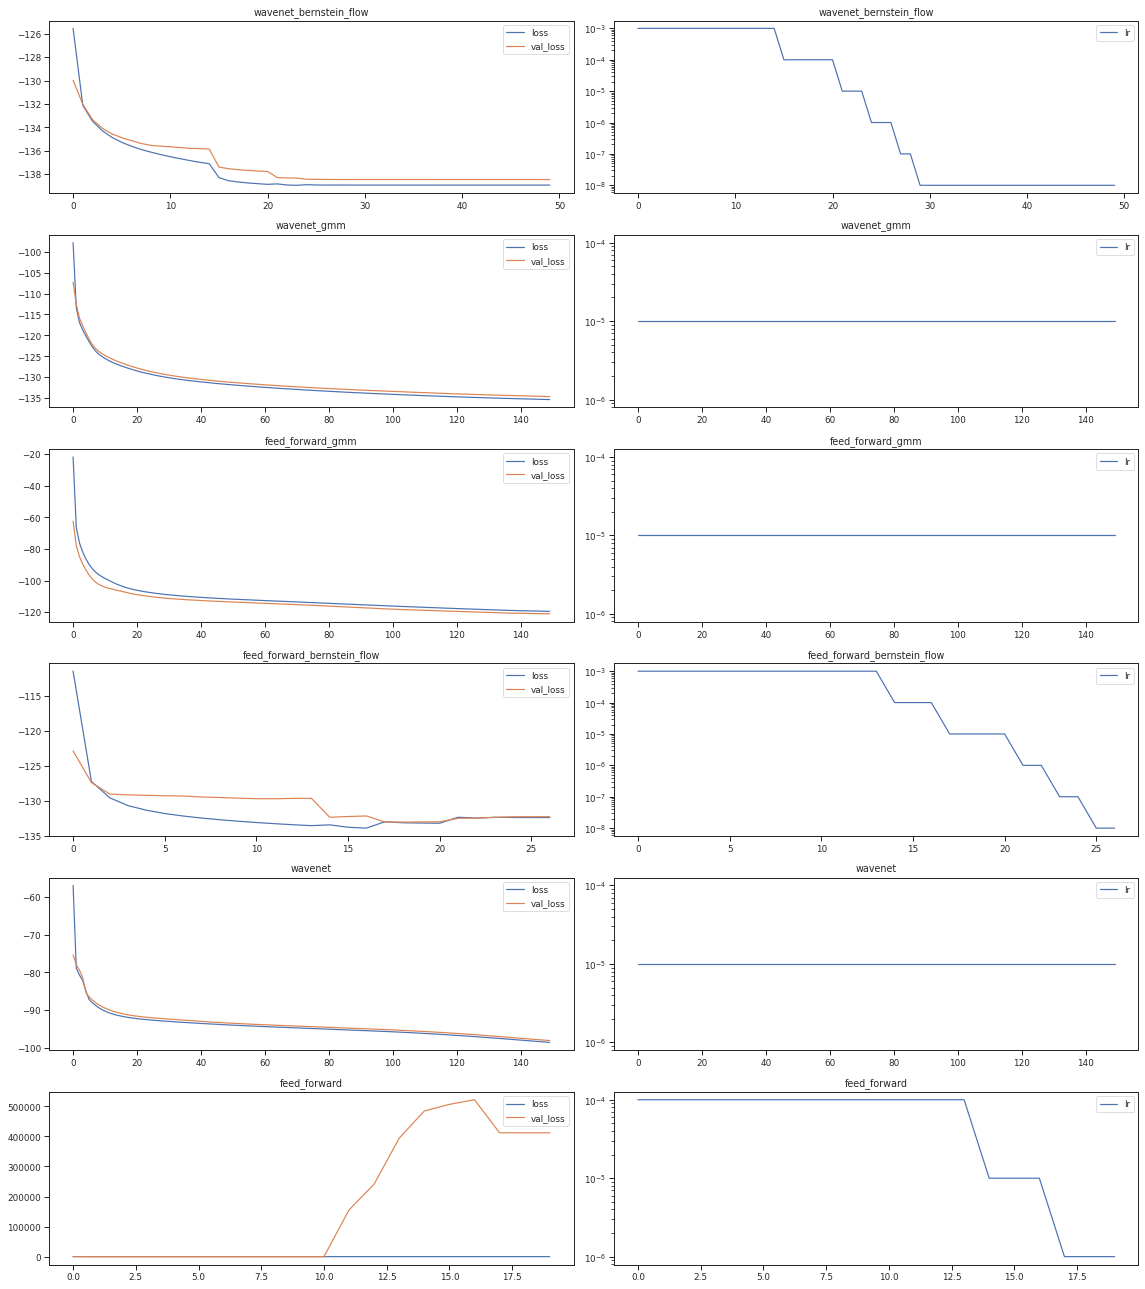

In [34]:
fig, ax = plt.subplots(len(hist_dfs),2, figsize=(16,3 * len(hist_dfs)))
if ax.size == 2:
    ax = ax[np.newaxis]
for i,(name,hist) in enumerate(hist_dfs.items()):
    hist[['loss','val_loss']].plot(title=name, ax=ax[i,0])
    hist[['lr']].plot(logy=True, title=name, ax=ax[i,1])
fig.tight_layout()

In [35]:
pd.DataFrame({name: hist.val_loss.describe() for name,hist in hist_dfs.items()})

,wavenet_bernstein_flow,wavenet_gmm,feed_forward_gmm,feed_forward_bernstein_flow,wavenet,feed_forward
count,50.000000,150.000000,150.000000,27.000000,150.000000,20.000000
mean,-137.194796,-131.117621,-114.033887,-130.633225,-93.738652,176993.957509
std,1.943848,4.232894,8.002847,2.295794,3.460661,215820.428681
min,-138.456741,-134.611740,-121.080391,-133.056625,-98.002029,-93.248047
25%,-138.455433,-133.738201,-118.990356,-132.374031,-95.695368,-89.620472
50%,-138.433052,-132.474106,-115.661686,-129.729187,-94.322842,-70.185574
75%,-135.792526,-130.271091,-112.346478,-129.404716,-92.782476,411963.203125
max,-129.968811,-107.267632,-62.437359,-122.884605,-75.350906,522110.031250


In [36]:
{name: hist.loss.min() for name,hist in hist_dfs.items()}

{'wavenet_bernstein_flow': -138.94831848144528,
 'wavenet_gmm': -135.32003784179688,
 'feed_forward_gmm': -119.50332641601562,
 'feed_forward_bernstein_flow': -133.91966247558594,
 'wavenet': -98.48633575439452,
 'feed_forward': -95.42755126953124}

In [37]:
{name: hist.val_loss.min() for name,hist in hist_dfs.items()}

{'wavenet_bernstein_flow': -138.45674133300778,
 'wavenet_gmm': -134.61174011230472,
 'feed_forward_gmm': -121.08039093017578,
 'feed_forward_bernstein_flow': -133.05662536621094,
 'wavenet': -98.00202941894531,
 'feed_forward': -93.248046875}

# Match Probabilistic Model

In [38]:
eval_models = [
    c for c in hist_dfs.keys()
]
eval_models

['wavenet_bernstein_flow',
 'wavenet_gmm',
 'feed_forward_gmm',
 'feed_forward_bernstein_flow',
 'wavenet',
 'feed_forward']

In [39]:
def match_prob_model(name):
    if 'flow' in name:
        return BernsteinFlow
    elif 'gmm' in name:
        return MixedNormal
    elif 'qunatile_regression' in name:
        return QuantileRegressionDistributionWrapper
    else:
        return NormalDistribution

In [40]:
prob_models={
    m: match_prob_model(m)
    for m in eval_models}
prob_models

{'wavenet_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow,
 'wavenet_gmm': bernstein_paper.distributions.mixed_normal.MixedNormal,
 'feed_forward_gmm': bernstein_paper.distributions.mixed_normal.MixedNormal,
 'feed_forward_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow,
 'wavenet': bernstein_paper.distributions.normal_distribution.NormalDistribution,
 'feed_forward': bernstein_paper.distributions.normal_distribution.NormalDistribution}

In [41]:
models

{'wavenet_bernstein_flow': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1b70849f70>,
 'wavenet_gmm': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1b705f4880>,
 'feed_forward_gmm': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1b705d1970>,
 'feed_forward_bernstein_flow': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1b70529580>,
 'wavenet': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1b70529280>,
 'feed_forward': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1b1c0a0310>}

In [42]:
prob_models

{'wavenet_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow,
 'wavenet_gmm': bernstein_paper.distributions.mixed_normal.MixedNormal,
 'feed_forward_gmm': bernstein_paper.distributions.mixed_normal.MixedNormal,
 'feed_forward_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow,
 'wavenet': bernstein_paper.distributions.normal_distribution.NormalDistribution,
 'feed_forward': bernstein_paper.distributions.normal_distribution.NormalDistribution}

# Load Data

In [43]:
cfg = cfgs[eval_models[0]]

In [44]:
dl_kwds=cfg.data_loader_kwds

dl_kwds.update({'cycle_length': 1, 'shuffle_buffer_size': 0, 'batch_size': 32, 'splits': ['train','test']})

dl_kwds

{'data_path': '../data/CER Electricity Revised March 2012/preprocessed/mini',
 'history_size': 336,
 'horizon_size': 48,
 'shift': 48,
 'historic_columns': ['load', 'is_holiday', 'tempC'],
 'horizon_columns': ['is_holiday', 'tempC'],
 'prediction_columns': ['load'],
 'validation_split': 0.1,
 'batch_size': 32,
 'cycle_length': 1,
 'shuffle_buffer_size': 0,
 'seed': 42,
 'splits': ['train', 'test']}

In [45]:
ds = cfg.data_loader(**dl_kwds)['test']

# Select Test Patch

In [46]:
batch_iter = ds.as_numpy_iterator()
test_x,test_y = next(batch_iter)

# Plot Forecast

quantile is not implemented: MixedNormal
quantile is not implemented: MixedNormal


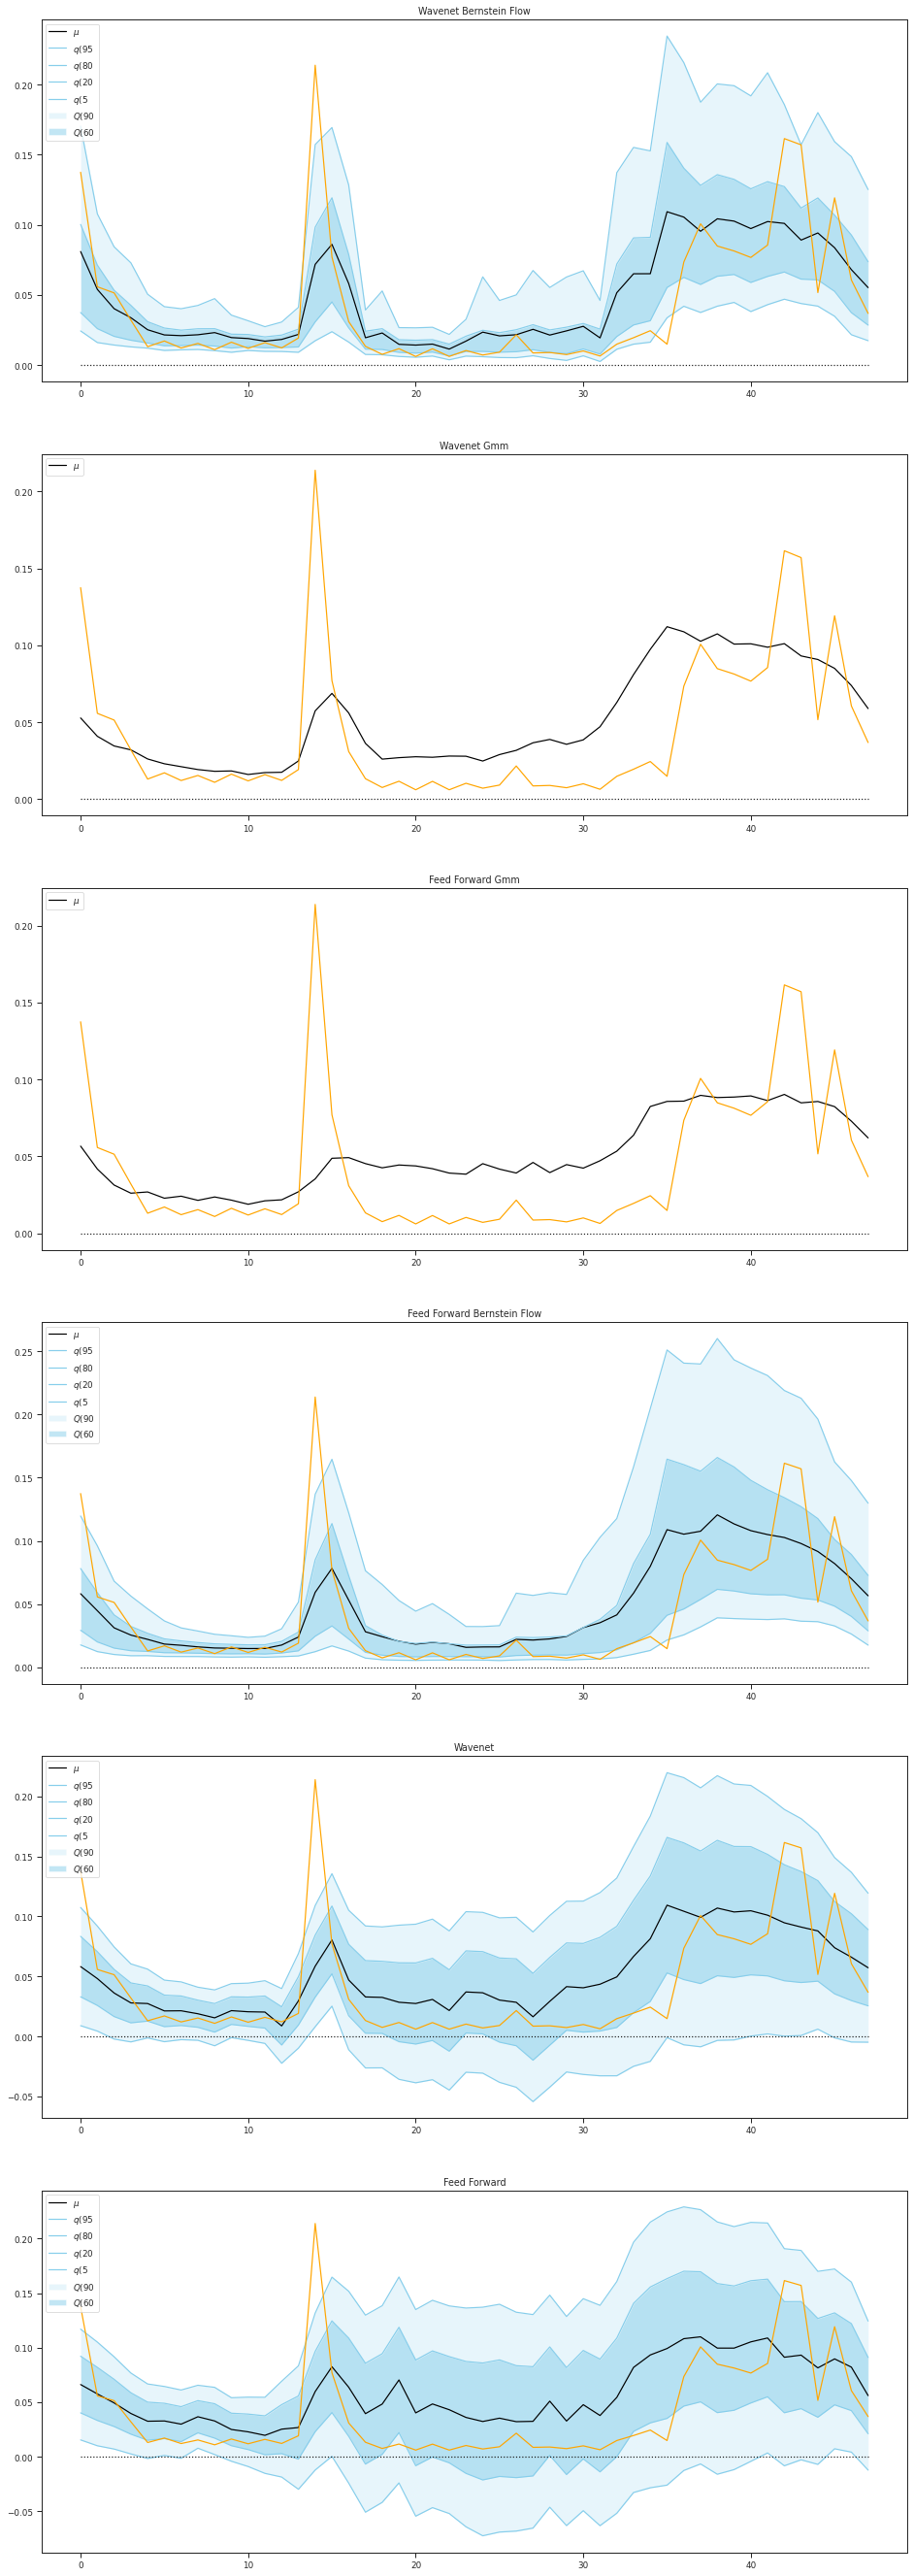

In [47]:
x=test_x[:1]
y=test_y[:1]

plots=len(eval_models)
fig, ax = plt.subplots(plots, figsize=(16,8*plots))

for i,m in enumerate(eval_models):
    
    if plots > 1:
        a = ax[i]
    else:
        a = ax
    df=plot_probabilistic_forecast(
        models[m],
        prob_models[m],
        x=x,
        ax=a
    )    
    a.plot(y.flatten(),color='orange',label='load')
    a.plot(np.zeros_like(y.flatten()),'k:')
    a.set_title(m.replace('_',' ').title())

# Bernstein flow

In [48]:
batch_iter = ds.as_numpy_iterator()
test_x,test_y = next(batch_iter)

In [49]:
m='feed_forward_bernstein_flow'
model=models[m]
pmodel=match_prob_model(m)
pv=model(test_x)
dist=pmodel(pv)

In [50]:
b2 = dist.bijector.bijector.bijectors[0].shift.numpy()
a2 = dist.bijector.bijector.bijectors[1].scale.numpy()
theta = dist.bijector.bijector.bijectors[2].theta.numpy()
b1 = dist.bijector.bijector.bijectors[4].shift.numpy()
a1 = dist.bijector.bijector.bijectors[5].scale.numpy()

In [51]:
print(f"""
a1 = {a1}
b1 = {b1}
theta = {theta}
a2 = {a2}
b2 = {b2}
""")


a1 = [[23.913895 31.529003 38.57793  ... 12.283247 12.835491 15.864393]
 [27.231733 33.654633 40.02475  ... 11.998728 13.051788 16.718071]
 [35.055874 39.999577 43.232433 ... 12.840743 15.677469 21.291283]
 ...
 [21.104088 24.99244  28.245867 ...  8.13354   9.445266 12.641539]
 [16.621386 19.632786 21.492914 ...  8.326852  9.088578 10.784166]
 [27.715294 30.551939 30.072525 ... 10.553817 13.243254 17.51768 ]]
b1 = [[0.373093   0.46445298 0.39092782 ... 0.35484526 0.20677419 0.02776615]
 [0.4632113  0.5419344  0.47527888 ... 0.5417205  0.41541755 0.1742783 ]
 [0.3850311  0.31654787 0.20286354 ... 0.69422257 0.5938828  0.2648457 ]
 ...
 [0.31191787 0.37863207 0.33499762 ... 0.50372434 0.36922652 0.13808525]
 [0.22952987 0.35708776 0.3387428  ... 0.47125062 0.3258226  0.06291772]
 [0.19982539 0.1787971  0.07708706 ... 0.59243023 0.4909804  0.17802739]]
theta = [[[-6.641256   -6.614633   -6.61156    ...  0.5927024   0.6198096
    2.7152648 ]
  [-6.230059   -6.216321   -6.1967015  ...  0.3

In [52]:
flows=pmodel(model(test_x[:1]))
flows

<tfp.distributions.BernsteinFlow 'BernsteinFlow' batch_shape=[1, 48] event_shape=[] dtype=float32>

KeyboardInterrupt: 

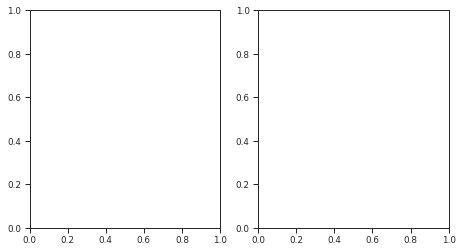

In [53]:
plot_chained_bijectors(flows)

# Stacked Density Plot

In [ ]:
day=5
#flot_save_ridge_plots(eval_models,(test_x1[day],test_x2[day]),test_y[day],'_ridge_plot_week')
for m in [m for m in eval_models]:
    fig, ax = stacked_dist_plot(models[m], prob_models[m], (test_x1[:1],test_x2[:1]), test_y[:1])
    fig.suptitle(m.replace('_',' ').title(), fontsize=24)

# Sampleing from the learned distribution

In [ ]:
from thesis.distributions import BersteinFlow as BersteinFlowOld

In [ ]:
m='wavenet_bernstein_flow'
param_model=models[m]
prob_model=prob_models[m]
prob_model_old=BersteinFlowOld(10)

In [ ]:
x=test_x[:1]
y=test_y[:1]
dist=prob_model(param_model(x))
dist_old=prob_model_old(param_model(x))
dist, dist_old

In [ ]:
dist.log_prob(tf.squeeze(y)).shape, dist_old.log_prob(tf.squeeze(y)).shape

In [ ]:
tfd.Independent(dist).log_prob(tf.squeeze(y)), dist_old.log_prob(tf.squeeze(y))

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#for x,y in tqdm(ds):
#    pv=param_model(x)
#    dist=prob_model(pv)
#    dist.sample()

In [ ]:
#from bernstein_flow.bijectors import BernsteinBijector

In [ ]:
#yy=np.linspace(-1,1)
#bjf=dist.bijector.inverse(yy[...,None,None])
#for d in range(bjf.shape[-1]):
#    plt.plot(yy,bjf[...,d])

In [ ]:
#yy=np.linspace(-0.02,0.07, 100)
#pb=dist.prob(yy[...,None,None])
#dists=pb.shape[-1]
#fig, ax = plt.subplots(dists, figsize=(16,4 * dists))
#for d in range(dists):
#    ax[d].plot(yy,pb[...,d])

In [ ]:
n=500
samples=np.squeeze(dist.sample(n))
samples.min(),samples.max()

In [ ]:
samples = samples[(samples.max(axis=1) < 2*y.max()) & (samples.min(axis=1) >0)]
samples.shape[1]

In [ ]:
fig = plt.figure(figsize=(16,8))
fig=plt.plot(samples.T, color='gray', alpha=.1)
plt.plot(y[0])

# Select Christmas Test Patch

In [ ]:
christmas_days = data.loc['2010-12-25':'2010-12-28']

In [ ]:
interesting_ids=(2.5*data.groupby('id').load.resample('D').sum().groupby('id').mean() < christmas_days.groupby('id').load.resample('D').sum().groupby('id').mean())
interesting_ids=interesting_ids[interesting_ids].index

In [ ]:
len(interesting_ids)

In [ ]:
christmas_patch = data.loc['2010-12-09':'2010-12-31']
christmas_patch = christmas_patch[christmas_patch.id.isin(interesting_ids)]
f'christmas week ranges from {christmas_patch.index.min()+pd.offsets.Week(2)} to {christmas_patch.index.max()}'

In [ ]:
len(np.unique(christmas_patch.index.date))

In [ ]:
pt=christmas_patch.pivot_table(index=christmas_patch.index.date,columns='id',values='load',aggfunc='sum')
days_per_id=pt.count()
incomplete_ids=days_per_id[days_per_id!=len(np.unique(christmas_patch.index.date))].index.tolist()
incomplete_ids

In [ ]:
christmas_patch =  christmas_patch[~christmas_patch.id.isin(incomplete_ids)]

In [ ]:
christmas_patch[christmas_patch.id.isin(interesting_ids)].pivot_table(columns='id',values='load',index='date_time').plot(figsize=(16,8),subplots=True)

In [ ]:
christmas_ds = gen_ds(christmas_patch[christmas_patch.id==2428])

In [ ]:
batch_iter = christmas_ds.as_numpy_iterator()
test_x,test_y = next(batch_iter)

In [ ]:
x=(test_x1[:5],test_x2[:5])
y=test_y[:5]

plots=len(eval_models)
fig, ax = plt.subplots(plots, figsize=(16,8*plots))

for i,m in enumerate(eval_models):
    df=plot_probabilistic_forecast(
        models[m],
        prob_models[m],
        x=x,
        ax=ax[i]
    )
    ax[i].plot(y.flatten(),color='orange',label='load')
    ax[i].plot(np.zeros_like(y.flatten()),'k:')
    ax[i].set_title(m.replace('_',' ').title())

## Plot Forecast

In [ ]:
#plot_save_plf(eval_models,test_x,test_y,postfix='_fc_christmas',concat_df=date_time)

## Stacked Density Plot

In [ ]:
#flot_save_ridge_plots(eval_models,test_x[day],test_y[day],'_ridge_plot_christmas')

# Evaluate on whole test data set

## NLL, MAE, MSE, CRPS, Pinball

In [54]:
metrics={}
for k,v in prob_models.items():
    metrics[k] = []
    metrics[k].append(MeanAbsoluteError(v, scale=12.8))
    metrics[k].append(MeanSquaredError(v, scale=12.8))
    metrics[k].append(ContinuousRankedProbabilityScore(v, scale=12.8))
metrics

{'wavenet_bernstein_flow': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7f1b88da8f70>,
 'wavenet_gmm': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7f1acc3ac7c0>,
 'feed_forward_gmm': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7f1acc30c1f0>,
 'feed_forward_bernstein_flow': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7f1acc39cc70>,
 'wavenet': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7f1aa84f8700>,
 'feed_forward': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7f1aa84019a0>,
  <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore at 0x7f1aa8451310>]}

In [55]:
eval_models

['wavenet_bernstein_flow',
 'wavenet_gmm',
 'feed_forward_gmm',
 'feed_forward_bernstein_flow',
 'wavenet',
 'feed_forward']

In [56]:
csv_files=sorted(file_list('.','thesis.csv'))
csv_files

['./scores-20210112-232326-thesis.csv', './scores-20210113-082715-thesis.csv']

In [59]:
if len(csv_files) > 0:
    scores_df = pd.read_csv(csv_files[-1], index_col=[0])
scores_df

,NLL,MAE,MSE,CRPS
Feed Forward,-81.905914,7.663205e-01,2.672960e+01,2.715804e-01
Feed Forward Bernstein Flow,-120.394440,3.322718e+08,3.962700e+22,1.995211e+07
Feed Forward Gmm,-111.334343,3.997224e-01,4.835533e-01,2.099148e-02
Wavenet,-92.354172,3.967997e-01,4.943868e-01,2.114734e-02
Wavenet Bernstein Flow,-127.327019,4.400419e-01,1.619350e+03,2.196619e-02
Wavenet Gmm,-124.438316,3.822177e-01,4.582193e-01,1.907703e-02


In [58]:
if 'scores_df' in globals():
    scores = {k.lower().replace(' ','_'): list(v.values()) for k,v in scores_df.to_dict('index').items()}
else:
    scores = {}
scores

{'feed_forward': [-81.90591430664062,
  0.766320526599884,
  26.729597091674805,
  0.27158039808273315],
 'feed_forward_bernstein_flow': [-120.39443969726562,
  332271808.0,
  3.962699748084753e+22,
  19952112.0],
 'feed_forward_gmm': [-111.33434295654295,
  0.3997223675251007,
  0.4835532903671265,
  0.020991483703255653],
 'wavenet': [-92.35417175292969,
  0.3967996537685394,
  0.4943868219852448,
  0.021147338673472404],
 'wavenet_bernstein_flow': [-127.32701873779295,
  0.4400419294834137,
  1619.35009765625,
  0.021966187283396717],
 'wavenet_gmm': [-124.43831634521484,
  0.382217675447464,
  0.4582193493843079,
  0.019077034667134285]}

In [60]:
em = list(sorted(set(eval_models) ^ set(map(lambda s: s.lower().replace(' ','_'), scores.keys()))))
em = eval_models
em

['wavenet_bernstein_flow',
 'wavenet_gmm',
 'feed_forward_gmm',
 'feed_forward_bernstein_flow',
 'wavenet',
 'feed_forward']

In [61]:
for m in em:
    compile_kwds=cfgs[m].compile_kwds
    compile_kwds['metrics'] = metrics[m]
    compile_kwds['loss'] = NegativeLogarithmicLikelihood(prob_models[m])
    compile_kwds['run_eagerly'] = True if ('flow' in m) else False
    print(m,compile_kwds)
    models[m].compile(**compile_kwds)
    scores[m]=models[m].evaluate(ds)
scores

wavenet_bernstein_flow {'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7f1acc2abac0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1b70669550>, 'metrics': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError object at 0x7f1b88da8f70>, <bernstein_paper.metrics.mean_squared_error.MeanSquaredError object at 0x7f1acc2cfa60>, <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore object at 0x7f1b207625e0>], 'run_eagerly': True}
680/680 [==============================] - 6957s 10s/step - loss: -127.3270 - mean_absolute_error: 0.3986 - mean_squared_error: 1330.5353 - continuous_ranked_probability_score: 0.0220
wavenet_gmm {'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7f1b70669ca0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1b705e4a00>, 'metrics': [<bernstein_paper

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


680/680 [==============================] - 4003s 6s/step - loss: -124.4383 - mean_absolute_error: 0.3461 - mean_squared_error: 0.3758 - continuous_ranked_probability_score: 0.0191
feed_forward_gmm {'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7f1a80c37d60>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1b7050dcd0>, 'metrics': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError object at 0x7f1acc30c1f0>, <bernstein_paper.metrics.mean_squared_error.MeanSquaredError object at 0x7f1acc24b7f0>, <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore object at 0x7f1acc2489d0>], 'run_eagerly': False}


680/680 [==============================] - 3689s 5s/step - loss: -111.3343 - mean_absolute_error: 0.3620 - mean_squared_error: 0.3966 - continuous_ranked_probability_score: 0.0210
feed_forward_bernstein_flow {'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7f1a7eeb58e0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1b1c0edeb0>, 'metrics': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError object at 0x7f1acc39cc70>, <bernstein_paper.metrics.mean_squared_error.MeanSquaredError object at 0x7f1acc39dfd0>, <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore object at 0x7f1aa84f87c0>], 'run_eagerly': True}
680/680 [==============================] - 5550s 8s/step - loss: -120.3944 - mean_absolute_error: 300455808.0000 - mean_squared_error: 32637773398938520387584.0000 - continuous_ranked_probability_score: 19952112.0000
wavenet {'loss': <bernstein_pape

680/680 [==============================] - 465s 683ms/step - loss: -92.3542 - mean_absolute_error: 0.3593 - mean_squared_error: 0.4055 - continuous_ranked_probability_score: 0.0211
feed_forward {'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7f1acc632340>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f1b147f1ee0>, 'metrics': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError object at 0x7f1aa84019a0>, <bernstein_paper.metrics.mean_squared_error.MeanSquaredError object at 0x7f1aa8466fa0>, <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore object at 0x7f1aa8451310>], 'run_eagerly': False}


680/680 [==============================] - 478s 704ms/step - loss: -81.9059 - mean_absolute_error: 0.6940 - mean_squared_error: 21.9221 - continuous_ranked_probability_score: 0.2716


{'feed_forward': [-81.90591430664062,
  0.6939931511878967,
  21.92211151123047,
  0.27158039808273315],
 'feed_forward_bernstein_flow': [-120.39443969726562,
  300455808.0,
  3.263777339893852e+22,
  19952112.0],
 'feed_forward_gmm': [-111.33434295654297,
  0.3619956374168396,
  0.39658322930336,
  0.020991483703255653],
 'wavenet': [-92.35417175292969,
  0.35934847593307495,
  0.40546825528144836,
  0.021147338673472404],
 'wavenet_bernstein_flow': [-127.32701873779297,
  0.39860138297080994,
  1330.5352783203125,
  0.02196618728339672],
 'wavenet_gmm': [-124.43831634521484,
  0.3461432456970215,
  0.37580540776252747,
  0.019077034667134285]}

In [62]:
#names = [cfgs[0].compile_kwds['loss'].name] + [m.name for m in cfgs[0].compile_kwds['metrics']]
index = [k.replace('_',' ').title() for k in scores.keys()]
columns = ['NLL','MAE','MSE','CRPS']
scores_df = pd.DataFrame(
    data=scores.values(),
    index=index,
    columns=columns
)

scores_df.sort_index()

,NLL,MAE,MSE,CRPS
Feed Forward,-81.905914,6.939932e-01,2.192211e+01,2.715804e-01
Feed Forward Bernstein Flow,-120.394440,3.004558e+08,3.263777e+22,1.995211e+07
Feed Forward Gmm,-111.334343,3.619956e-01,3.965832e-01,2.099148e-02
Wavenet,-92.354172,3.593485e-01,4.054683e-01,2.114734e-02
Wavenet Bernstein Flow,-127.327019,3.986014e-01,1.330535e+03,2.196619e-02
Wavenet Gmm,-124.438316,3.461432e-01,3.758054e-01,1.907703e-02


In [63]:
scores_df.to_csv(datetime.now().strftime("scores-%Y%m%d-%H%M%S-thesis.csv"))

# NLL Box Plot

In [164]:
from tqdm.notebook import tqdm

In [166]:
nlls={}
m_iter = tqdm([m for m in em if 'flow' in m])
dl_kwds['batch_size'] = 1
ds_dict=cfg.data_loader(**dl_kwds)
ds_iter = tqdm(ds_dict)
for m in m_iter:
    m_iter.set_postfix_str(m)
    compile_kwds=cfgs[m].compile_kwds
    if 'metrics' in compile_kwds.keys():
        compile_kwds.pop('metrics')
    compile_kwds['loss'] = NegativeLogarithmicLikelihood(prob_models[m], reduction=tf.keras.losses.Reduction.NONE)
    compile_kwds['run_eagerly'] = False
    models[m].compile(**compile_kwds)
    nlls[m]={}
    for dsk in ds_iter:
        ds_iter.set_postfix(ds = dsk)
        ds = ds_dict[dsk]
        nlls[m][dsk]=[]
        for x,y in tqdm(ds):
            nll=models[m].evaluate(x,y, verbose=False)
            nlls[m][dsk].append(nll)
            ds_iter.set_postfix({'loss': nll})
nlls

{'wavenet_bernstein_flow': {'train': [-119.51396179199219,
   -117.92918395996094,
   -133.55599975585938,
   -124.16876220703125,
   -108.16978454589844,
   -107.18655395507812,
   -120.25723266601562,
   -130.06448364257812,
   -125.94711303710938,
   -145.60147094726562,
   -141.5543975830078,
   -139.41302490234375,
   -130.72080993652344,
   -150.77053833007812,
   -147.8606719970703,
   -146.71864318847656,
   -135.37478637695312,
   -117.93138122558594,
   -125.631591796875,
   -139.4228973388672,
   -149.78936767578125,
   -141.68896484375,
   -148.12307739257812,
   -148.0141143798828,
   -148.28439331054688,
   -153.9111328125,
   -147.10086059570312,
   -154.47271728515625,
   -145.5639190673828,
   -144.75189208984375,
   -143.768798828125,
   -145.1721649169922,
   -151.92103576660156,
   -137.4697723388672,
   -154.2264404296875,
   -174.20376586914062,
   -171.37496948242188,
   -147.57846069335938,
   -155.62046813964844,
   -134.6033172607422,
   -133.37103271484375,
 

In [269]:
nlls_df=pd.DataFrame(pd.concat([pd.DataFrame.from_dict(d, orient='index').stack() for d in nlls.values()], keys=nlls.keys()))
nlls_df.reset_index([0,1], inplace=True)
nlls_df.columns=['model', 'ds', 'loss']
nlls_df

,model,ds,loss
0,wavenet_bernstein_flow,train,-119.513962
1,wavenet_bernstein_flow,train,-117.929184
2,wavenet_bernstein_flow,train,-133.556000
3,wavenet_bernstein_flow,train,-124.168762
4,wavenet_bernstein_flow,train,-108.169785
...,...,...,...
675,feed_forward_bernstein_flow,test,-116.175812
676,feed_forward_bernstein_flow,test,-112.453979
677,feed_forward_bernstein_flow,test,-104.033951
678,feed_forward_bernstein_flow,test,-111.044067


(-436.28030853271486, 100.0)

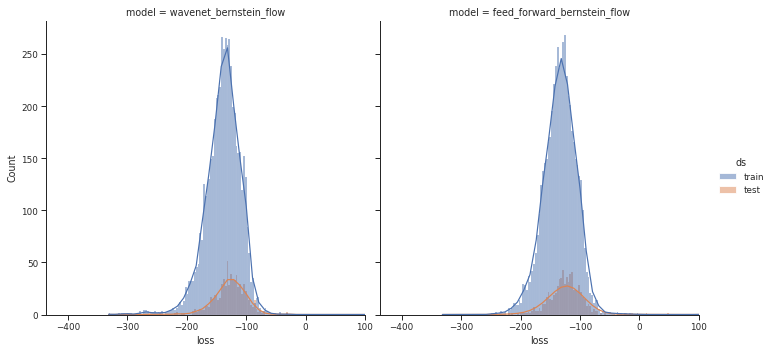

In [264]:
sns.displot(data=nlls_df, hue='ds', x='loss', col='model', kde=True)
plt.xlim(None, 100)

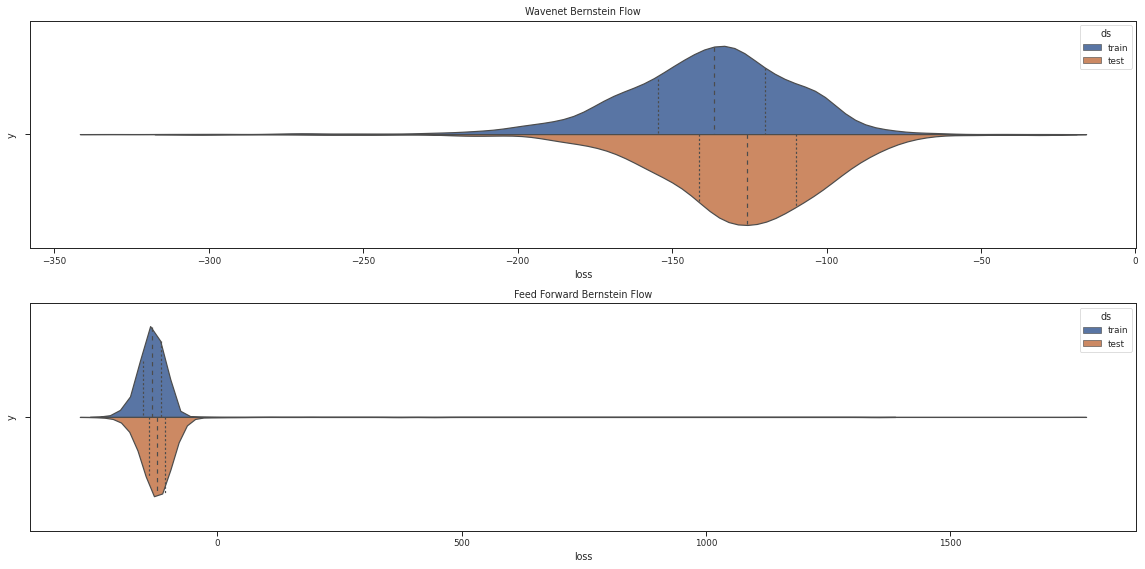

In [330]:
model_ids = nlls_df.model.unique()
f, ax = plt.subplots(len(model_ids),figsize=(16,8), sharex=False)
for a,m in zip(ax, model_ids):
    sns.violinplot(
        data=nlls_df[nlls_df.model == m ].assign(y=''),
        y='y',
        x='loss',
        hue='ds',
        split=True,
        inner='quart',
        ax=a)
    a.set_title(m.replace('_', ' ').title())
    
plt.tight_layout()

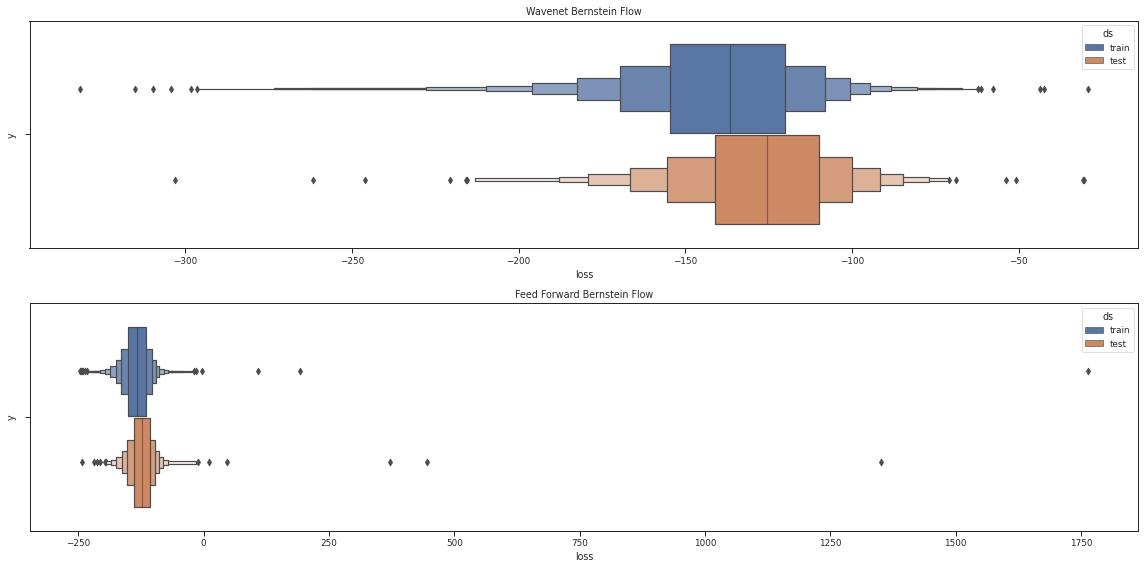

In [329]:
model_ids = nlls_df.model.unique()
f, ax = plt.subplots(len(model_ids),figsize=(16,8), sharex=False)
for a,m in zip(ax, model_ids):
    sns.boxenplot(
        data=nlls_df[nlls_df.model == m ].assign(y=''),
        y='y',
        x='loss',
        hue='ds',
        ax=a)
    a.set_title(m.replace('_', ' ').title())
    
plt.tight_layout()